In [1]:
from ICARUS.core.types import FloatArray
from ICARUS.vehicle.plane import Airplane
from ICARUS.vehicle.surface import WingSurface
from ICARUS.vehicle.utils import SymmetryAxes
from ICARUS.vehicle.plane import Airplane
from ICARUS.vehicle.wing_segment import WingSegment
from ICARUS.computation.solvers.AVL.analyses.polars import avl_angle_run, process_avl_angles_run
from ICARUS.environment.definition import EARTH_ISA
from ICARUS.flight_dynamics.state import State
from ICARUS.database import DB3D
from ICARUS.vehicle.control_surface import ControlSurface, Elevator, Flap


In [2]:
import numpy as np
origin= np.array([0.0, 0.0, 0.0], dtype=float)

wing_position= np.array(
    [0.0, 0.0, 0.0],
    dtype=float,
)
wing_orientation=np.array(
    [-1.0, 1.0, 0.0],
    dtype=float,
)

main_wing_flap = Flap(
    span_positions=(0., 0.35),
    hinge_chord_percentages= (0.75, 0.75),
    chord_extension= 1.
)

elevator = Elevator(
    span_positions= (0., 1.),
    hinge_chord_percentages= (0.5, 0.5)
)

main_wing = WingSegment(
    name="wing",
    root_airfoil="4415",
    origin=origin + wing_position,
    orientation=wing_orientation,
    symmetries=SymmetryAxes.Y,
    span=2 * 1.130,
    sweep_offset=0,
    root_chord=0.159,
    tip_chord=0.072,
    twist_root=0,
    twist_tip=0,
    N=15,
    M=5,
    mass=0.670,
    controls= [main_wing_flap] 
)

elevator_pos: FloatArray = np.array(
    [0.54, 0.0, 0.0],
    dtype=float,
)
elevator_orientantion: FloatArray = np.array(
    [0.0, 0.0, 0.0],
    dtype=float,
)

hor_stabilizer = WingSegment(
    name="elevator",
    root_airfoil="NACA0008",
    origin=origin + elevator_pos,
    orientation=elevator_orientantion,
    symmetries=SymmetryAxes.Y,
    span=2 * 0.169,
    sweep_offset=0,
    root_dihedral_angle=0,
    root_chord=0.130,
    tip_chord=0.03,
    N=15,
    M=5,
    mass=0.06,
    controls= [elevator]
)

rudder_position: FloatArray = np.array(
    [0.47, 0.0, 0.01],
    dtype=float,
)
rudder_orientation: FloatArray = np.array(
    [0.0, 0.0, 90.0],
    dtype=float,
)

rudder = WingSegment(
    name="rudder",
    root_airfoil="NACA0008",
    origin=origin + rudder_position,
    orientation=rudder_orientation,
    symmetries=SymmetryAxes.NONE,
    span=0.160,
    sweep_offset=0.1,
    root_dihedral_angle=0,
    root_chord=0.2,
    tip_chord=0.1,
    N=15,
    M=5,
    mass=0.04,
)

lifting_surfaces: list[WingSurface] = [main_wing, hor_stabilizer, rudder]

point_masses = [
    (0.500, np.array([-0.40, 0.0, 0.0], dtype=float), "engine"),  # Engine
    (1.000, np.array([0.090, 0.0, 0.0], dtype=float), "structure"),  # Structure
    # (1.000, np.array([0.090, 0.0, 0.0], dtype=float), "battery"),  # Battery
    (0.900, np.array([0.130, 0.0, 0.0], dtype=float), "payload"),  # Payload
]

In [3]:
planes = []
for d in [0, 10, 20, 30 , 40]:
    if d < 0:
        ch = "p"
    else: 
        ch = "n"
    plane = Airplane(f"plane_with_{ch}{abs(d)}_flap",lifting_surfaces)
    plane.add_point_masses(point_masses)
    UINF = 20
    solver2D = "Xfoil"
    angles = np.linspace(-10, 10, 11)

    state = State(
            name="Unstick",
            airplane=plane,
            environment=EARTH_ISA,
            u_freestream= UINF,
    )

    epsilons = {
        "u": 0.01,
        "w": 0.01,
        "q": 0.1,
        "theta": 0.01,
        "v": 0.01,
        "p": 0.1,
        "r": 0.1,
        "phi": 0.01,
    }
    # print(state.control_vars)
    state.set_control(
        {
            "delta_f" : d,
            "delta_e" : 0,  
        }
    )
    state.add_all_pertrubations("Central", epsilons)
    avl_angle_run(
        plane = plane,
        state = state,
        solver2D= "Xfoil",
        angles=angles
    )
    process_avl_angles_run(
        plane = plane,
        state = state,
        angles = angles
    )
    planes.append(plane.name)

Searching for airfoil naca4415 in DB2D
Loading airfoil naca4415 from DB2D
Searching for airfoil naca0008 in DB2D
Loading airfoil naca0008 from DB2D


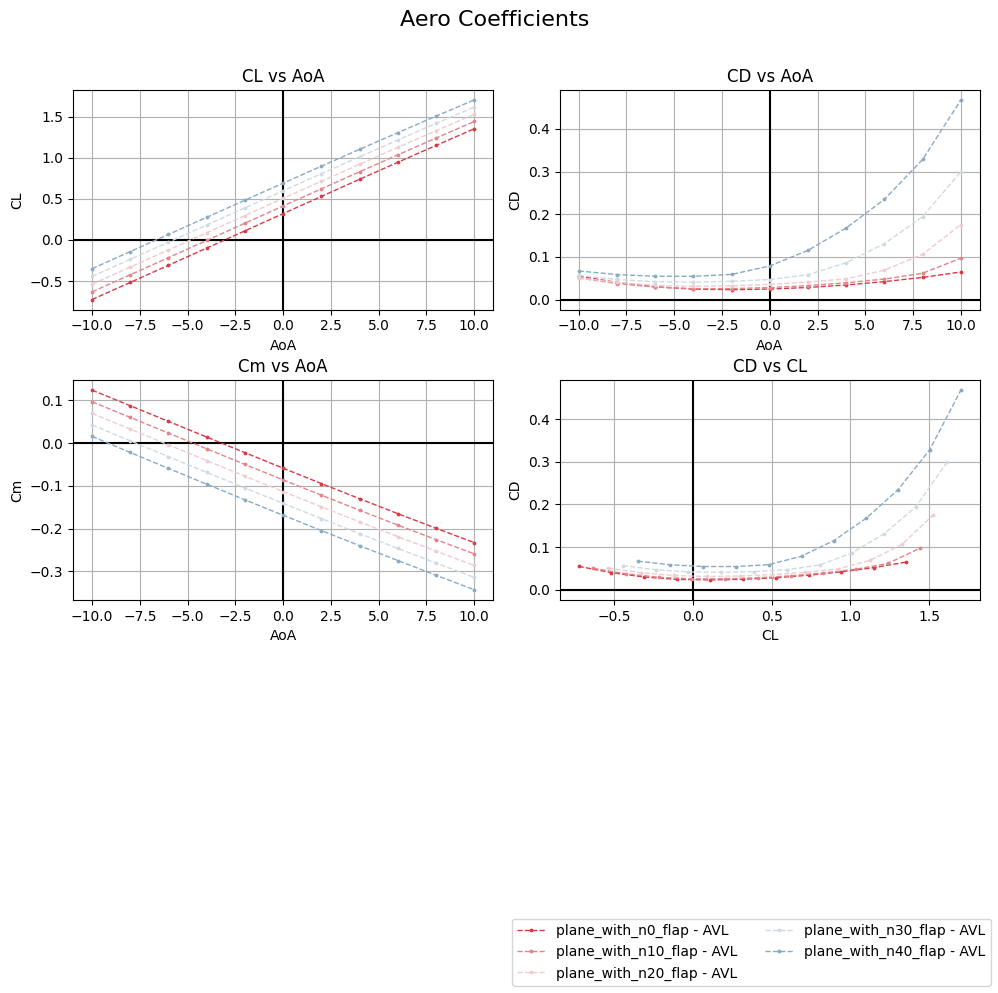

(array([[<Axes: title={'center': 'CL vs AoA'}, xlabel='AoA', ylabel='CL'>,
         <Axes: title={'center': 'CD vs AoA'}, xlabel='AoA', ylabel='CD'>],
        [<Axes: title={'center': 'Cm vs AoA'}, xlabel='AoA', ylabel='Cm'>,
         <Axes: title={'center': 'CD vs CL'}, xlabel='CL', ylabel='CD'>],
        [<Axes: >, <Axes: >]], dtype=object),
 <Figure size 1000x1000 with 4 Axes>)

In [4]:
from ICARUS.visualization.airplane.db_polars import plot_airplane_polars as plot
plot(planes, solvers = ['AVL'])